# A Toy example for likelihood misspecification under Huber contaminated data

Note that for the comaprison with PVI, we can see that if the likelihood is Gaussian and the prior is also Gaussian, then the model is conjugate and the posterior will be another Gaussian. Therefore, and as the variational family chosen is the set of Gaussian distributions, we can apply Lemma 2 and Corollary 4 to see that the PVI posterior (where the divergences are the KL divergence and the loss function is the negative log likelihood) will recover the traditional Bayesian posterior. And since this is available in closed form, we do not do unnecessary computations for this toy experiment. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import math
from __future__ import division
import copy


import torch
import torch.utils.data
import torch.nn as nn
from torch import distributions, nn, optim
from torchvision import transforms, datasets
from scipy.stats import multivariate_normal
import scipy.stats as stats
import numpy as np

from fedgvi_synthetics.Client import weighting_functions
from fedgvi_synthetics.Server import Server
from fedgvi_synthetics.Server2 import Server2
from fedgvi_synthetics.helper_functions import helper_functions, Gaussian
from fedgvi_synthetics.Divergences import Divergences
from fedgvi_synthetics.Bayes import Bayes


from tueplots import bundles
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    #'font.family': 'serif', 
    #'text.usetex': True,
    #'pgf.rcfonts': False,
})#Tueplots with aistats2023 takes care of font parameters
#import tqdm.auto as tqdm
#import pandas as pd

JITTER = 1e-8

%matplotlib inline
device = 'cpu'
torch.set_default_dtype(torch.float64)
torch.set_default_device(device = device)

In [2]:
def plot_training(training_array, name):
    x_vals = np.arange(1, len(training_array)+1)
    plt.figure(figsize=(6,4))
    plt.grid(visible=True)
    plt.plot(x_vals, training_array)
    plt.ylabel(name)
    plt.xlabel('Step')
    plt.show()

cs = [(255/255,176/255,0/255),(254/255,97/255,0/255),(220/255,38/255,127/255), 
      (120/255,94/255,240/255),(100/255,143/255,255/255)]

In [3]:
a = torch.ones(10)
b = torch.zeros(10)

# Toy examples
----

# Misspecified Likelihood

75


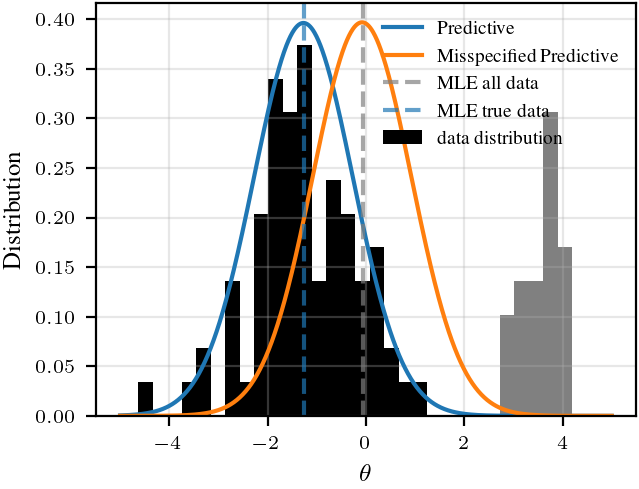

tensor([-1.2612])

In [4]:
#Generate Data
torch.manual_seed(86_965_667)
prior_loc = torch.tensor([0.])
prior_scale = torch.tensor([0.5])
loc_well = torch.tensor([-2.])
loc_mis = torch.tensor([3.])
scale_well = torch.tensor([1.])
scale_mis = torch.tensor([0.5])
epsilon = 0.25
num_samples = 100

theta = distributions.normal.Normal(prior_loc, prior_scale).sample((1,))

num_well = int(np.floor((1-epsilon) * num_samples))
print(num_well)
st_well = torch.distributions.normal.Normal(theta[0] + loc_well, scale_well)
st_mis = torch.distributions.normal.Normal(theta[0] + loc_mis, scale_mis)
samples_well = st_well.sample((num_well,))
samples_mis = st_mis.sample(((num_samples-num_well),))

samples_ = torch.cat([samples_well, samples_mis], 0)

samp = samples_.cpu().numpy()


m_true, s_true = Bayes.exact_posterior_1D(samples_well, scale_well, loc_well, scale_well, num_well)
m_mis, s_mis = Bayes.exact_posterior_1D(samples_, scale_well, loc_well, scale_well, num_samples)
m_mle_, v_mle_ = Bayes.maximum_likelihood(samples_)
mle_well, _ = Bayes.maximum_likelihood(samples_well)
x = np.linspace(-5, 5, 1000)

rvtrue = stats.norm(m_true.cpu(),s_true.cpu())
predtrue = stats.norm(m_true.cpu(), torch.sqrt((s_true.cpu() ** 2) + (scale_well.cpu() ** 2)))

rvmis = stats.norm(m_mis.cpu(),s_mis.cpu())
predmis = stats.norm(m_mis.cpu(), torch.sqrt((s_mis.cpu() ** 2) + (scale_well.cpu() ** 2)))

with plt.rc_context(bundles.aistats2023()):
    fig, ax = plt.subplots(figsize = (3.25, 2.5), dpi = 200)

    #ax.plot(x, rvtrue.pdf(x), label="Posterior")
    ax.plot(x, predtrue.pdf(x), label="Predictive")
    
    #ax.plot(x, rvmis.pdf(x), label=r"Misspecified Posterior")
    ax.plot(x, predmis.pdf(x), label=r"Misspecified Predictive")
    
    ax.axvline(m_mle_.cpu().numpy(), color="grey", linestyle="dashed", alpha=0.7, label="MLE all data")
    ax.axvline(mle_well.cpu().numpy(), linestyle="dashed", alpha=0.7, label="MLE true data")

    
    _, bins, patches = ax.hist(samp, density=True, bins=30, label="data distribution", color='black')  

    for i in range(np.argmax(bins>=2.0), len(bins)-1):
        patches[i].set_facecolor('grey')
    
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel("Distribution")
    ax.legend(loc="upper right", frameon=False)
    
    ax.grid(visible=True, alpha=.3)
    #plt.savefig("unimodal_mix_1d.png")
    plt.show()
mle_well

In [5]:
c = 2.5

In [6]:
# Split the Data into different clients:
num_clients = 7
#client_data_ = [samples_well, samples_mis]
client_data_ = helper_functions.homogeneous_split(samples_, num_clients)

In [ ]:
parameters_ = {
    "a": (scale_well ** 2),
    "D": 1,
    "N": num_samples,
    "Epochs": 50,
    "global_div": "KLD",
    "global_div_param": 0.6,
    "lr": 1e-3,
    "samples": 50,
    "optim_epochs": 500,
    "batch_size": 50   
}
prior = {
    "loc": torch.tensor(m_mle_),
    "var": torch.tensor([1.0], device=device)
}
q_global_ = {
    "loc": torch.nn.Parameter(m_mle_),
    "var": torch.nn.Parameter(prior["var"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}
client_idx = 0
clients_ = []
for data_set in client_data_:
    clients_.append({
        "client_idx": client_idx,
        "x_n": data_set.to(device=device),
        "mean": torch.tensor([0.], device=device),
        "variance": torch.tensor([np.inf], device=device),
        "variance_inverse": torch.tensor([0.], device=device),
        "normaliser": torch.tensor(1., device=device),
        "iteration": 0,
        "true_v": parameters_["a"],
        "spherical": True,
        "require_s_n": False,
        "Divergence": "KLD",
        "div_param": 1.15,
        "loss": "score_matching",
        "score_function": "SE",
        "loss_param": c,
    })
    client_idx += 1

In [8]:
q1_ = copy.deepcopy(q_global_)
c1_ = copy.deepcopy(clients_)
p1_ = copy.deepcopy(parameters_)
p1_.update({"Epochs": 40})

In [9]:
q_l, prior_l, clients_l = Server().FedGVI(q1_, c1_, p1_, is_1d=True, minibatch=False,  conjugate=True)

Starting global q:  {'loc': Parameter containing:
tensor([-0.0600], requires_grad=True), 'var': Parameter containing:
tensor([1.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Parameter containing:
tensor([-0.0600], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Client 0
Conjugate Update:
Cavity: loc:  tensor([-0.0600])  var:  tensor([1.])
Cavity distribution:  {'loc': tensor([-0.0600]), 'var': tensor([1.])}
New approximation: loc:  tensor([-0.7428])  var:  tensor([0.0967])
This should match the previous: 
 Returned client approximation: loc:  tensor([-0.7428])  var:  tensor([0.0967])
New client likelihood:  {'mean': tensor([-0.8158]), 'variance': tensor([0.1070]), 'variance_inverse': tensor([9.3434]), 'normaliser': None}
Client 1
Conjugate Update:
Cavity: loc:  tensor([-0.0600])  var:  tensor([1.])
Cavity distribution:  {'loc': tensor([-0.0600]), 'var': tensor([1.])}
New approximation: loc:  tensor([-1.0439])  var:  tens

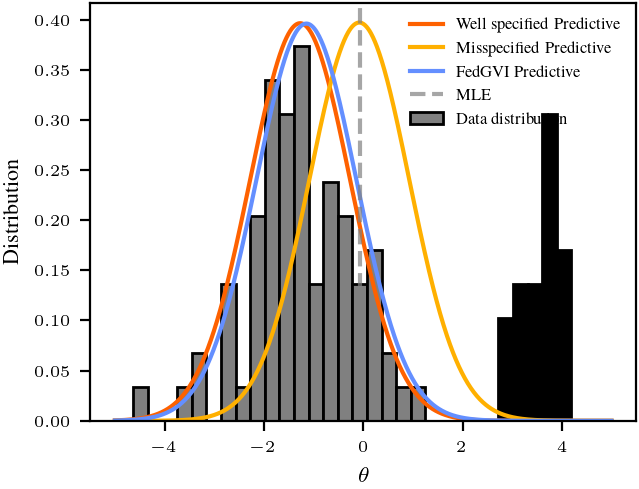

In [10]:
x = np.linspace(-5, 5, 1000)

rvtrue = stats.norm(m_true.cpu(),s_true.cpu())
predtrue = stats.norm(m_true.cpu(), torch.sqrt((s_true.cpu() ** 2) + (scale_well.cpu() ** 2)))

rvmis = stats.norm(m_mis.cpu(),s_mis.cpu())
predmis = stats.norm(m_mis.cpu(), torch.sqrt((s_mis.cpu() ** 2) + (scale_well.cpu() ** 2)))

rvfedgvi = stats.norm(q_l["loc"].detach().cpu(), torch.sqrt(q_l["var"].detach().cpu()))
predfedgvi = stats.norm(q_l["loc"].detach().cpu(), torch.sqrt(q_l["var"].detach().cpu() + (scale_well.cpu() ** 2)))
with plt.rc_context(bundles.icml2024()):
    fig, ax = plt.subplots(figsize = (3.25, 2.5), dpi = 200)
    #ax.plot(x, rvtrue.pdf(x), label="Posterior")
    ax.plot(x, predtrue.pdf(x), label="Well specified Predictive", color=cs[1])
    
    #ax.plot(x, rvmis.pdf(x), label=r"Misspecified Posterior")
    ax.plot(x, predmis.pdf(x), label=r"Misspecified Predictive", color=cs[0])
    
    #ax.plot(x, rvfedgvi.pdf(x), label=r"FedGVI Posterior SE")
    ax.plot(x, predfedgvi.pdf(x), label=r"FedGVI Predictive", color=cs[4])
    
    ax.axvline(m_mle_.cpu().numpy(), color="grey", linestyle="dashed", alpha=0.7, label="MLE")
    
    #ax.hist(samp, density=True, bins=30, label="data distribution", color="#552D62")

    _, bins, patches = ax.hist(samp, density=True, bins=30, label="Data distribution", color='grey', edgecolor= 'black')  

    for i in range(np.argmax(bins>=2.0), len(bins)-1):
        patches[i].set_facecolor('black')

    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel("Distribution")
    ax.legend(loc="upper right", frameon=False)
    
    #ax.grid(visible=True, alpha=.3)
    #plt.savefig("unimodal_mix_1d.png")
    plt.show()

In [11]:
q2_ = copy.deepcopy(q_global_)
#q2_.update({"loc": torch.nn.Parameter(torch.tensor([1.], device=device))})
c2_ = copy.deepcopy(clients_)
for client in c2_:
    client.update({"loss": "beta", "loss_param": 1.15})
p2_ = copy.deepcopy(parameters_)
p2_.update({"Epochs": 35, "global_div": "KLD"})

In [12]:
q_l2, prior_l2, clients_l2 = Server().FedGVI(q2_, c2_, p2_, is_1d=True, minibatch=False,  conjugate=False)

Starting global q:  {'loc': Parameter containing:
tensor([-0.0600], requires_grad=True), 'var': Parameter containing:
tensor([1.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Parameter containing:
tensor([-0.0600], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Client 0
Cavity: loc:  tensor([-0.0600])  var:  tensor([1.])
Client  0  updates as:  {'mean': tensor([-1.1667]), 'variance': tensor([1.7271]), 'variance_inverse': tensor([0.5790]), 'normaliser': None} 
 With cavity distribution:  {'loc': tensor([-0.0600]), 'var': tensor([1.])}  and current approx:  Parameter containing:
tensor([-0.4658], requires_grad=True) Parameter containing:
tensor([0.6333], requires_grad=True)
Client 1
Cavity: loc:  tensor([-0.0600])  var:  tensor([1.])
Client  1  updates as:  {'mean': tensor([-1.1214]), 'variance': tensor([1.7093]), 'variance_inverse': tensor([0.5850]), 'normaliser': None} 
 With cavity distribution:  {'loc': tensor([-0.0600

In [13]:
q3_ = copy.deepcopy(q_global_)
q3_.update({"loc": torch.nn.Parameter(torch.tensor([15.], device=device))})
c3_ = copy.deepcopy(clients_)
for client in c3_:
    client.update({"loss": "score_matching", "score_function": "IMQ","loss_param": 0.9})
p3_ = copy.deepcopy(parameters_)
p3_.update({"Epochs": 100, "global_div": "AR", "global_div_param": 1.25})
q_l3, prior_l3, clients_l3 = Server2().FedGVI(q3_, c3_, p3_, is_1d=True, minibatch=False,  conjugate=True)

Starting global q:  {'loc': Parameter containing:
tensor([15.], requires_grad=True), 'var': Parameter containing:
tensor([1.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Parameter containing:
tensor([15.], requires_grad=True) Parameter containing:
tensor([1.], requires_grad=True)
Client 0
Conjugate Update:
Cavity: loc:  tensor([15.])  var:  tensor([1.])
Cavity distribution:  {'loc': tensor([15.]), 'var': tensor([1.])}
New approximation: loc:  tensor([14.2250])  var:  tensor([0.9473])
This should match the previous: 
 Returned client approximation: loc:  tensor([14.2250])  var:  tensor([0.9473])
New client likelihood:  {'mean': tensor([0.2987]), 'variance': tensor([17.9692]), 'variance_inverse': tensor([0.0557]), 'normaliser': None}
Client 1
Conjugate Update:
Cavity: loc:  tensor([15.])  var:  tensor([1.])
Cavity distribution:  {'loc': tensor([15.]), 'var': tensor([1.])}
New approximation: loc:  tensor([14.1842])  var:  tensor([0.9407])
This should

In [14]:
Bayes.exact_posterior_1D(samples_well, scale_well, m_mle_, q_global_["var"].detach(), num_well)

(tensor([-1.2454]), tensor([0.1147]))

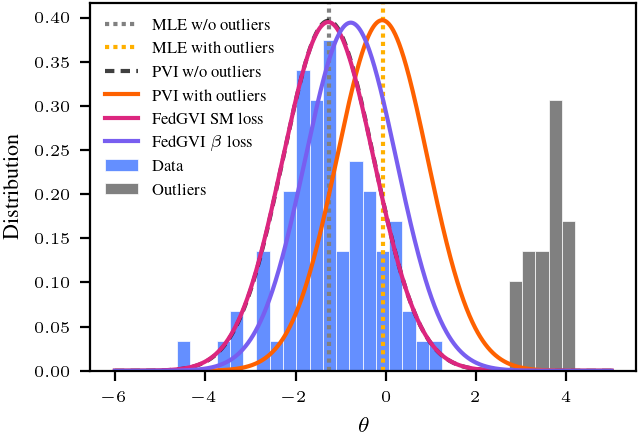

In [15]:
x = np.linspace(-6, 5, 1000)

rvtrue = stats.norm(m_true,s_true)
predtrue = stats.norm(m_true, torch.sqrt((s_true ** 2) + (scale_well ** 2)))

rvmis = stats.norm(m_mis,s_mis)
predmis = stats.norm(m_mis, torch.sqrt((s_mis ** 2) + (scale_well ** 2)))

rvfedgvi = stats.norm(q_l3["loc"].detach(), torch.sqrt(q_l3["var"].detach()))
predfedgvi = stats.norm(q_l3["loc"].detach(), torch.sqrt(q_l3["var"].detach() + (scale_well ** 2)))

rvfedgvi2 = stats.norm(q_l2["loc"].detach(), torch.sqrt(q_l2["var"].detach()))
predfedgvi2 = stats.norm(q_l2["loc"].detach(), torch.sqrt(q_l2["var"].detach() + (scale_well ** 2)))
with plt.rc_context(bundles.icml2024()):
    fig, ax = plt.subplots(figsize = (3.25, 2.25), dpi = 200)
    #ax.plot(x, rvtrue.pdf(x), label="Posterior")
    ax.axvline(mle_well.numpy(), color="grey", linestyle=(0,(1.,1.)), label="MLE w/o outliers")
    ax.axvline(m_mle_.numpy(), color=cs[0], linestyle=(0,(1.,1.)), label="MLE with outliers")
    ax.plot(x, predtrue.pdf(x), label="PVI w/o outliers", c='black',alpha=.75, linestyle=(0,(2.25,1.5)))
    
    #ax.plot(x, rvmis.pdf(x), label=r"Misspecified Posterior")
    ax.plot(x, predmis.pdf(x), label=r"PVI with outliers", c=cs[1])#, linestyle=(0,(2.25,1.5)))
    
    #ax.plot(x, rvfedgvi.pdf(x), label=r"fedgvi Posterior beta")
    ax.plot(x, predfedgvi.pdf(x), label=r"FedGVI SM loss", c=cs[2])
    ax.plot(x, predfedgvi2.pdf(x), label=r"FedGVI $\beta$ loss", c=cs[3])
    
    _, bins, patches = ax.hist(samp, density=True, bins=30, label="Data", color=cs[4], edgecolor='white', linewidth=0.25)  

    for i in range(np.argmax(bins>=2.0), len(bins)-1):
        patches[i].set_facecolor('grey')
    patches[np.argmax(bins>=2.0)].set_label('Outliers')
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel("Distribution")
    ax.legend(loc="upper left", frameon=False)
    
    #ax.grid(visible=True, alpha=.3)
    #fig.savefig('./figs/like_misspec.png', format="png", bbox_inches= "tight", pad_inches=0)
    plt.show()


# Influence Function

In [ ]:
client_data_if = torch.load("./saved_tensors/client_data.pt")

In [17]:
samples_st = torch.cat((client_data_if[0], client_data_if[1]))

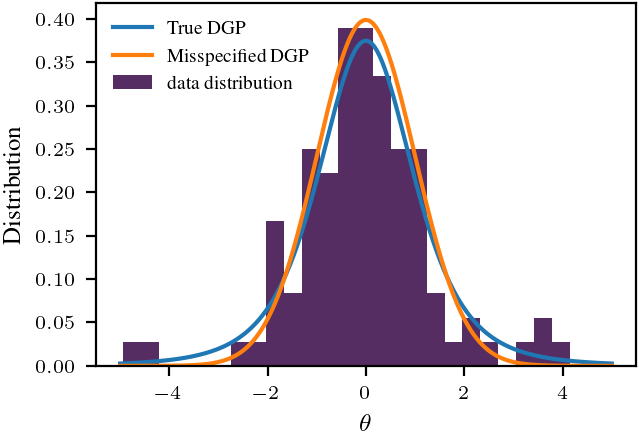

In [18]:
#Generate Data
torch.manual_seed(86_962_999)

df = torch.tensor([4])
mean = torch.tensor([0.])
var = torch.tensor([1.])
num_samples = 99

st = torch.distributions.studentT.StudentT(df=4.0, loc=0.0, scale=1.0)
samples_st = st.sample((num_samples,))

samp_st = samples_st.cpu().numpy()

x = np.linspace(-5, 5, 1000)

rvtrue_st = stats.t(df, mean, var)
rvmisspec = stats.norm(mean, var)
with plt.rc_context(bundles.aistats2023()):
    fig, ax = plt.subplots(figsize = (3.25, 2.25), dpi = 200)
    ax.plot(x, rvtrue_st.pdf(x), label="True DGP")
    ax.plot(x, rvmisspec.pdf(x), label="Misspecified DGP")
    
    ax.hist(samp_st, density=True, bins=25, label="data distribution", color="#552D62")
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel("Distribution")
    ax.legend(loc="upper left", frameon=False)
    
    #ax.grid(visible=True, alpha=.3)
    #plt.savefig("unimodal_mix_1d.png")
    plt.show()

In [19]:
num_clients = 7
client_data_if = helper_functions.homogeneous_split(samples_st, num_clients)

In [20]:
parameters_if = {
    "a": var,
    "D": 1,
    "N": num_samples,
    "Epochs": 3,
    "global_div": "KLD",
    "global_div_param": 2.0,
    "lr": 1e-3,
    "samples": 50,
    "optim_epochs": 500,
    "batch_size": 50   
}
prior_if = {
    "loc": torch.tensor([-1.], device=device),
    "var": torch.tensor([10.0], device=device)
}
q_global_if = {
    "loc": torch.nn.Parameter(prior_if["loc"]),
    "var": torch.nn.Parameter(prior_if["var"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}
client_idx = 0
clients_if = []
for data_set in client_data_if:
    clients_if.append({
        "client_idx": client_idx,
        "x_n": None,
        "mean": torch.tensor([0.], device=device),
        "variance": torch.tensor([np.inf], device=device),
        "variance_inverse": torch.tensor([0.], device=device),
        "normaliser": torch.tensor(1., device=device),
        "iteration": 0,
        "true_v": parameters_if["a"],
        "spherical": True,
        "require_s_n": False,
        "Divergence": "KLD",
        "div_param": 1.0,
        "loss": "nll",
        "score_function": "IMQ",
        "loss_param": 2*torch.quantile(samples_st, 0.95),
    })
    client_idx += 1

In [21]:
m_true_if, s_true_if = Bayes.exact_posterior_1D(samples_st, var ** 0.5, prior_if["loc"], prior_if["var"] ** 0.5, num_samples+1)
loc_Bayes, var_Bayes = m_true_if, s_true_if ** 2
loc_Bayes, var_Bayes

(tensor([-0.0170]), tensor([0.0100]))

In [22]:
max_data_point = 26
base = torch.tensor([1.0])
missspecified_points = []
for i in range(max_data_point):
    missspecified_points.append(i * base)

In [23]:
missspec_data_sets = []
missspec_qs = []
missspec_clients = []

for x in missspecified_points:
    temp = copy.deepcopy(client_data_if)
    temp[num_clients-1] = torch.cat((temp[num_clients-1], x))
    missspec_data_sets.append(temp)
    temp_q = copy.deepcopy(q_global_if)
    missspec_qs.append(temp_q)
    temp_c = copy.deepcopy(clients_if)
    temp_cli = []
    for i in range(num_clients):
        temp_c[i].update({"x_n": temp[i]})
    missspec_clients.append(temp_c)

In [24]:
nll_qs = copy.deepcopy(missspec_qs)
imq_qs = copy.deepcopy(missspec_qs)
se_qs = copy.deepcopy(missspec_qs)

nll_cs = copy.deepcopy(missspec_clients)
imq_cs = copy.deepcopy(missspec_clients)
se_cs = copy.deepcopy(missspec_clients)
for i in range(max_data_point):
    for j in range(num_clients):
        imq_cs[i][j].update({"loss": "score_matching", "score_function": "IMQ"})
        se_cs[i][j].update({"loss": "score_matching", "score_function": "SE"})

nll_results = []
imq_results = []
se_results = []

In [25]:
parameters_if.update({"Epochs": 20})
for i in range(max_data_point):
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print("Negative Log Likelihood")
    print("Data point: ", i)
    q_temp_nll, _, _ = Server().FedGVI(nll_qs[i], nll_cs[i], parameters_if, is_1d=True, minibatch=False, conjugate=True)
    nll_results.append(q_temp_nll)
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print("IMQ Kernel score matching")
    print("Data point: ", i)
    q_temp_imq, _, _ = Server().FedGVI(imq_qs[i], imq_cs[i], parameters_if, is_1d=True, minibatch=False,  conjugate=True)
    imq_results.append(q_temp_imq)
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print("SE Kernel score matching")
    print("Data point: ", i)
    q_temp_se, _, _ = Server().FedGVI(se_qs[i], se_cs[i], parameters_if, is_1d=True, minibatch=False,  conjugate=True)
    se_results.append(q_temp_se)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Negative Log Likelihood
Data point:  0
Starting global q:  {'loc': Parameter containing:
tensor([-1.], requires_grad=True), 'var': Parameter containing:
tensor([10.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Parameter containing:
tensor([-1.], requires_grad=True) Parameter containing:
tensor([10.], requires_grad=True)
Client 0
Conjugate Update:
Cavity: loc:  tensor([-1.])  var:  tensor([10.])
Cavity distribution:  {'loc': tensor([-1.]), 'var': tensor([10.])}
New approximation: loc:  tensor([0.1033])  var:  tensor([0.0662])
This should match the previous: 
 Returned client approximation: loc:  tensor([0.1033])  var:  tensor([0.0662])
New client likelihood:  {'mean': tensor([0.1107]), 'variance': tensor([0.0667]), 'variance_inverse': tensor([15.]), 'normaliser': None}
Client 1
Conjugate Update:
Cavity: loc:  tensor([-1.])  var:  tensor([10.])
Cavity distribu

In [26]:
parameters_if.update({"Epochs": 20})
q_temp = copy.deepcopy(q_global_if)
clients = copy.deepcopy(clients_if)
t_data = torch.cat((samples_st, torch.tensor([0.])))
clients[0].update({"x_n": t_data})
client = [clients[0]]
assert len(client[0]["x_n"])==100

q_temp_true, _, _ = Server().FedGVI(q_temp, client, parameters_if, is_1d=True, minibatch=False, conjugate=True)

Starting global q:  {'loc': Parameter containing:
tensor([-1.], requires_grad=True), 'var': Parameter containing:
tensor([10.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Parameter containing:
tensor([-1.], requires_grad=True) Parameter containing:
tensor([10.], requires_grad=True)
Client 0
Conjugate Update:
Cavity: loc:  tensor([-1.])  var:  tensor([10.])
Cavity distribution:  {'loc': tensor([-1.]), 'var': tensor([10.])}
New approximation: loc:  tensor([-0.0170])  var:  tensor([0.0100])
This should match the previous: 
 Returned client approximation: loc:  tensor([-0.0170])  var:  tensor([0.0100])
New client likelihood:  {'mean': tensor([-0.0160]), 'variance': tensor([0.0100]), 'variance_inverse': tensor([100.]), 'normaliser': None}
Server Update 
 New approximation at the server:  {'loc': Parameter containing:
tensor([-0.0170], requires_grad=True), 'var': Parameter containing:
tensor([0.0100], requires_grad=True), 'metrics': {'elbos': [], 'kls':

In [ ]:
#nll_results = torch.load('./saved_tensors/nll_results.pt')
#imq_results = torch.load('./saved_tensors/iqm_results.pt')
#se_results = torch.load('./saved_tensors/se_results.pt')
gamma_results = torch.load("./saved_tensors/gamma_results.pt")
beta_results = torch.load("./saved_tensors/beta_results.pt")

In [ ]:
#Takes long, so import from saved tensors from results shown below
gamma_qs = copy.deepcopy(missspec_qs)

gamma_cs = copy.deepcopy(missspec_clients)
for i in range(max_data_point):
    for j in range(num_clients):
        gamma_cs[i][j].update({"loss": "gamma", "loss_param": 1.05})
#Uncomment to run instead
"""
gamma_results = []

parameters_if.update({"Epochs": 20})
for i in range(max_data_point):
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print("Gamma Loss Function")
    print("Data point: ", i)
    q_temp_gamma, _, _ = Server().FedGVI(gamma_qs[i], gamma_cs[i], parameters_if, is_1d=True, minibatch=False,  conjugate=False)
    gamma_results.append(q_temp_gamma)

In [ ]:
#Takes long, so import from saved tensors from results shown below
beta_qs = copy.deepcopy(missspec_qs)

beta_cs = copy.deepcopy(missspec_clients)
for i in range(max_data_point):
    for j in range(num_clients):
        beta_cs[i][j].update({"loss": "beta", "loss_param": 1.05})

#uncomment to run with beta loss function instead of loading results
"""
beta_results = []

parameters_if.update({"Epochs": 20})
for i in range(max_data_point):
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print("Beta Loss Function")
    print("Data point: ", i)
    q_temp_beta, _, _ = Server().FedGVI(beta_qs[i], beta_cs[i], parameters_if, is_1d=True, minibatch=False,  conjugate=False)
    beta_results.append(q_temp_beta)

In [29]:
fr_nll_ = []
fr_imq_ = []
fr_se_ = []
fr_gamma_ = []
fr_beta_ = []
for i in range(max_data_point):
    fr_nll_.append(Divergences().FisherRao_normals(nll_results[i]["loc"].detach(), nll_results[0]["loc"].detach(), nll_results[i]["var"].detach() , nll_results[0]["var"].detach()))
    fr_imq_.append(Divergences().FisherRao_normals(imq_results[i]["loc"].detach(), imq_results[0]["loc"].detach(), imq_results[i]["var"].detach(), imq_results[0]["var"].detach()))
    fr_se_.append(Divergences().FisherRao_normals(se_results[i]["loc"].detach(), se_results[0]["loc"].detach(), se_results[i]["var"].detach(), se_results[0]["var"].detach()))
    fr_gamma_.append(Divergences().FisherRao_normals(gamma_results[i]["loc"].detach(), gamma_results[0]["loc"].detach(), gamma_results[i]["var"].detach(), gamma_results[0]["var"].detach()))
    fr_beta_.append(Divergences().FisherRao_normals(beta_results[i]["loc"].detach(), beta_results[0]["loc"].detach(), beta_results[i]["var"].detach(), beta_results[0]["var"].detach()))


In [30]:
t = missspecified_points[0]
fr_nll = fr_nll_[0]
fr_imq = fr_imq_[0]
fr_se = fr_se_[0]
fr_gamma = fr_gamma_[0]
fr_beta = fr_beta_[0]
for i in range(1, max_data_point):
    t = torch.cat((t, missspecified_points[i]))
    fr_nll = torch.cat((fr_nll, fr_nll_[i]))
    fr_imq = torch.cat((fr_imq, fr_imq_[i]))
    fr_se = torch.cat((fr_se, fr_se_[i]))
    fr_gamma = torch.cat((fr_gamma, fr_gamma_[i]))
    fr_beta = torch.cat((fr_beta, fr_beta_[i]))

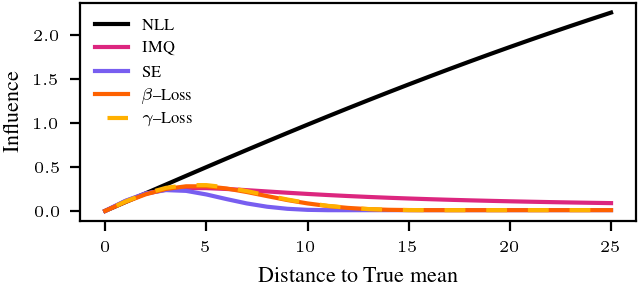

In [31]:
with plt.rc_context(bundles.icml2024()):
    fig, ax = plt.subplots(figsize = (3.25, 1.5), dpi = 200)

    ax.plot(t, fr_nll, label = r"NLL", color="black")#, label=r"KL with $\log p_m(x_{1:m}|\theta)$"
    ax.plot(t, fr_imq, label=r"IMQ", color=cs[2])#, label=r"$D_{AR}^{(0.5)}$ with $\log p_m(x_{1:m}|\theta)$"
    ax.plot(t, fr_se, label=r"SE", color=cs[3])#, label=r"$D_{AR}^{(0.5)}$ with $\mathcal{L}_B^{1.05}(\mathcal{N}(x_{1:m}|\theta, \Sigma))$"
    
    ax.plot(t, fr_beta, label=r"$\beta$--Loss", color=cs[1])
    ax.plot(t, fr_gamma, label=r"$\gamma$--Loss", color=cs[0], dashes=[0,3,2])
    ax.legend(loc="upper left", frameon=False)
    ax.set_xlabel("Distance to True mean")
    ax.set_ylabel("Influence")
    #ax.grid(visible=False, alpha=.3)
    #fig.savefig('./figs/if.png', format="png", bbox_inches= "tight", pad_inches=0)
    plt.show()

### Using the KL divergence instead of the Fisher-Rao distance

In [32]:
kl_nll_ = []
kl_imq_ = []
kl_se_ = []
kl_gamma_ = []
kl_beta_ = []
conf = {"D": 1}
for i in range(max_data_point):
    kl_nll_.append(Divergences().kl_spherical_gaussian(nll_results[i]["loc"].detach(), nll_results[0]["loc"].detach(), nll_results[i]["var"].detach() , nll_results[0]["var"].detach(), conf))
    kl_imq_.append(Divergences().kl_spherical_gaussian(imq_results[i]["loc"].detach(), imq_results[0]["loc"].detach(), imq_results[i]["var"].detach(), imq_results[0]["var"].detach(), conf))
    kl_se_.append(Divergences().kl_spherical_gaussian(se_results[i]["loc"].detach(), se_results[0]["loc"].detach(), se_results[i]["var"].detach(), se_results[0]["var"].detach(), conf))
    kl_gamma_.append(Divergences().kl_spherical_gaussian(gamma_results[i]["loc"].detach(), gamma_results[0]["loc"].detach(), gamma_results[i]["var"].detach(), gamma_results[0]["var"].detach(), conf))
    kl_beta_.append(Divergences().kl_spherical_gaussian(beta_results[i]["loc"].detach(), beta_results[0]["loc"].detach(), beta_results[i]["var"].detach(), beta_results[0]["var"].detach(), conf))

In [33]:
t = missspecified_points[0]
kl_nll = kl_nll_[0]
kl_imq = kl_imq_[0]
kl_se = kl_se_[0]
kl_gamma = kl_gamma_[0]
kl_beta = kl_beta_[0]
for i in range(1, max_data_point):
    t = torch.cat((t, missspecified_points[i]))
    kl_nll = torch.cat((kl_nll, kl_nll_[i]))
    kl_imq = torch.cat((kl_imq, kl_imq_[i]))
    kl_se = torch.cat((kl_se, kl_se_[i]))
    kl_gamma = torch.cat((kl_gamma, kl_gamma_[i]))
    kl_beta = torch.cat((kl_beta, kl_beta_[i]))

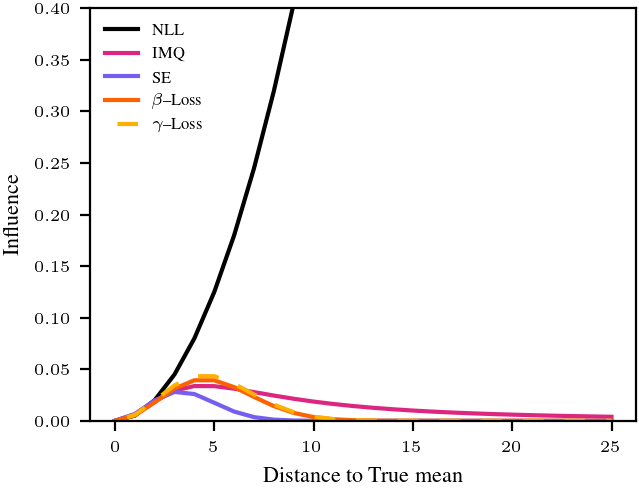

In [34]:
with plt.rc_context(bundles.icml2024()):
    fig, ax = plt.subplots(figsize = (3.25, 2.5), dpi = 200)

    ax.plot(t, kl_nll, label = r"NLL", color="black")#, label=r"KL with $\log p_m(x_{1:m}|\theta)$"
    ax.plot(t, kl_imq, label=r"IMQ", color=cs[2])#, label=r"$D_{AR}^{(0.5)}$ with $\log p_m(x_{1:m}|\theta)$"
    ax.plot(t, kl_se, label=r"SE", color=cs[3])#, label=r"$D_{AR}^{(0.5)}$ with $\mathcal{L}_B^{1.05}(\mathcal{N}(x_{1:m}|\theta, \Sigma))$"
    
    ax.plot(t, kl_beta, label=r"$\beta$--Loss", color=cs[1])
    ax.plot(t, kl_gamma, label=r"$\gamma$--Loss", color=cs[0], dashes=[0,3,2])
    ax.legend(loc="upper left", frameon=False)
    ax.set_xlabel("Distance to True mean")
    ax.set_ylabel("Influence")
    ax.set_ylim((0,0.4))
    #ax.grid(visible=False, alpha=.3)
    #fig.savefig('./figs/if_kl.png', format="png", bbox_inches= "tight", pad_inches=0)
    plt.show()

In [35]:
#Saving tensors for Influence Function
torch.save(client_data_if, './saved_tensors/client_data.pt')
torch.save(nll_results, './saved_tensors/nll_results.pt')
torch.save(imq_results, './saved_tensors/iqm_results.pt')
torch.save(se_results, './saved_tensors/se_results.pt')
torch.save(gamma_results, './saved_tensors/gamma_results.pt')
torch.save(beta_results, './saved_tensors/beta_results.pt')
